Começando pelos imports básicos:

In [96]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


Verificando os datasets:

In [99]:
df_test = pd.read_csv('teste.csv')

In [7]:
df_test = pd.read_csv('teste.csv')
df_train = pd.read_csv('treino.csv')

df_train.head()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [17]:
np.sum(df_train.inadimplente)/df.shape[0]

0.06664545454545455

Como podemos ver, trata-se de um problema com classes desbalanceadas. A acurácia provavelmente não vai ser uma métrica do problema, pois um modelo que retorna um caso negativo de fraude estará correto ~94% das vezes. Assim, para avaliar estes modelos utilazremos as métricas de recall, precisão, e f1.

Há um trade-off entre recall e precisão. Se o recall for baixo, pode-se perder alguns inadimplentes, porém, se a precisão for baixa, gera-se falsos positivos. Dependendo do caso de uso deste modelo, uma das métricas tem de ser priorizada.

Checando valores nulos presentes no dataset:

In [8]:
df_train.shape[0] == df_train.dropna().shape[0]

False

In [11]:
df_train[df_train.isnull().any(axis=1)]

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
6,0,0.305682,57,0,5710.0,NaN,8,0,3,0,0.0
8,0,0.116951,27,0,46.0,NaN,2,0,0,0,NaN
16,0,0.061086,78,0,2058.0,NaN,10,0,2,0,0.0
32,0,0.083418,62,0,977.0,NaN,6,0,1,0,0.0
41,0,0.072898,81,0,75.0,NaN,7,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
109980,0,1.000000,80,0,35.0,NaN,0,0,0,0,0.0
109986,0,0.938906,84,0,5734.0,NaN,5,0,1,0,0.0
109990,0,0.535453,60,0,1619.0,NaN,7,0,1,0,0.0
109993,0,0.102095,59,0,2389.0,NaN,6,0,1,0,0.0


Dado que existem valores nulos de salário mensal e não sabemos se esse valor pode ser imputado checamos se as linhas sem o valor de salário representam uma porcentagem significativa dos inadimplentes.

In [13]:
df_train.shape

(110000, 11)

In [16]:
np.sum(df_train.inadimplente)/df.shape[0] 

0.06664545454545455

In [14]:
np.sum(df_train[df_train.isnull().any(axis=1)].inadimplente)/df_train[df_train.isnull().any(axis=1)].shape[0]

0.0572990856040068

In [15]:
np.sum(df_train[df_train.isnull().any(axis=1)].inadimplente)/np.sum(df_train.inadimplente)

0.17009957713818033

Como podemos ver, a quantidade de inadimplentes que são valores nulos na coluna de salária representam 17% de todos os inadimplentes. Assim, não é trivial descartar os dados nulos presentes no dataset.

In [18]:
# Checando slários que são zero

df_train.loc[df_train.salario_mensal == 0]

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
14,0,0.019657,76,0,477.0,0.0,6,0,1,0,0.0
50,0,0.818978,73,0,3095.0,0.0,9,0,1,1,0.0
73,0,0.059669,31,0,3162.0,0.0,11,0,2,0,1.0
90,0,0.039388,51,0,15466.0,0.0,7,0,0,0,0.0
298,0,0.085152,25,0,1005.0,0.0,5,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
108994,0,0.001706,74,0,15.0,0.0,10,0,0,0,0.0
109207,0,0.676427,46,0,2527.0,0.0,13,0,1,0,0.0
109243,0,0.020704,39,0,1403.0,0.0,3,0,1,0,0.0
109510,0,0.240635,55,0,54.0,0.0,3,0,0,0,0.0


Dado que existem valores iguas a 0 na coluna de salário, descarta-se a hipótese dos valores nulos corresponderem à falta de renda fixa.

Assim, para não perdermos dados imputamos a mediana do salario mensal substituindo os valores nulos de salário. Fazemos o mesmo para número de dependentes.

In [40]:
df_train['salario_mensal'] = df_train['salario_mensal'].fillna(value=np.median(df_train['salario_mensal'].dropna()))
df_train['numero_de_dependentes'] = df_train['numero_de_dependentes'].fillna(value=np.median(df_train['numero_de_dependentes'].dropna()))

In [41]:
# Checando se há mais NaNs

df_train.shape[0] == df_train.dropna().shape[0]

True

Como os dados são desbalanceados, será feito um oversampling da categoria menos frequente. Porém, antes de ser aplicado o oversampling, vamos dividir o dataset de treino em treino e validação.

In [54]:
x, y = df_train.drop('inadimplente', axis=1), df_train['inadimplente']
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [55]:
over_sampler = SMOTE()
x_overs, y_overs = over_sampler.fit_resample(x_train, y_train)

Na etapa de modelagem, começaremos com um modelo menos complexo sendo este o modelo de regressão logística.

In [88]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(x_overs, y_overs)

LogisticRegression(max_iter=1000)

In [89]:
log_pred = log_model.predict(x_val)
log_pred_proba = log_model.predict_proba(x_val)

<AxesSubplot:>

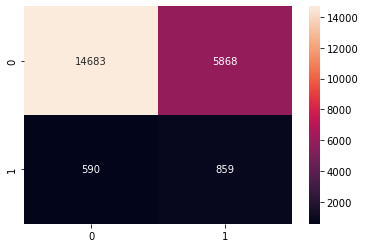

In [90]:
log_cm = confusion_matrix(y_val, log_pred)
sns.heatmap(log_cm, annot=True, fmt='g')

In [91]:
log_recall = log_cm[0,0]/(log_cm[0,0]+log_cm[1,0])
log_precision = log_cm[0,0]/(log_cm[0,0]+log_cm[0,1])

print(log_recall, log_precision)

0.9613697374451646 0.714466449321201


Embora a performance do modleo de regressão de logística aparenta ser adequada, avaliaremos se um modelo mais complexo consegue obter uma performance melhor.

In [84]:
xgmodel = xgboost.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
xgmodel.fit(x_overs, y_overs)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [85]:
xgpred = xgmodel.predict(x_val)
xgpred_proba = xgmodel.predict_proba(x_val)

<AxesSubplot:>

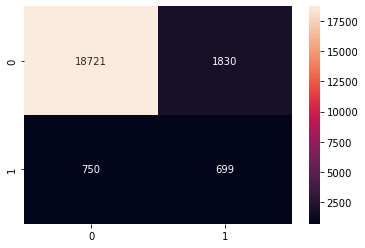

In [86]:
xgcm = confusion_matrix(y_val, xgpred)
sns.heatmap(xgcm, annot=True, fmt='g')

In [87]:
xgrecall = xgcm[0,0]/(xgcm[0,0]+xgcm[1,0])
xgprecision = xgcm[0,0]/(xgcm[0,0]+xgcm[0,1])

print(xgrecall, xgprecision)

0.9614811771352267 0.9109532382852416


Como a performace do xgboost foi melhor, nota-se que é um problema suficientemente complexo para o uso de um modelo mais avançado. Assim, ele será usado para gerar a predição final de probabilidade de risco de crédito.

In [100]:
test_proba = xgmodel.predict_proba(df_test)

In [102]:
test_proba

array([[0.8145932 , 0.18540677],
       [0.6363969 , 0.3636031 ],
       [0.65906274, 0.3409373 ],
       ...,
       [0.2880385 , 0.7119615 ],
       [0.03756982, 0.9624302 ],
       [0.9674908 , 0.03250918]], dtype=float32)

In [103]:
df_test['inadimplente'] = test_proba[:,1]
df_test

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0,0.185407
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0,0.363603
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0,0.340937
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0,0.352252
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0,0.078912
...,...,...,...,...,...,...,...,...,...,...,...
39995,0.000000,68,1,0.062858,10833.0,9,1,0,0,0.0,0.005045
39996,0.061117,84,0,0.013598,8456.0,7,0,0,0,0.0,0.008877
39997,0.817745,70,0,0.663056,6000.0,17,0,2,0,0.0,0.711962
39998,0.106139,64,2,0.865438,5045.0,12,0,4,0,0.0,0.962430


Importância de cada variável no modelo

In [121]:
pesos = xgmodel.get_booster().get_score(importance_type='weight')

/home/vmendes/miniconda3/envs/dsml_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

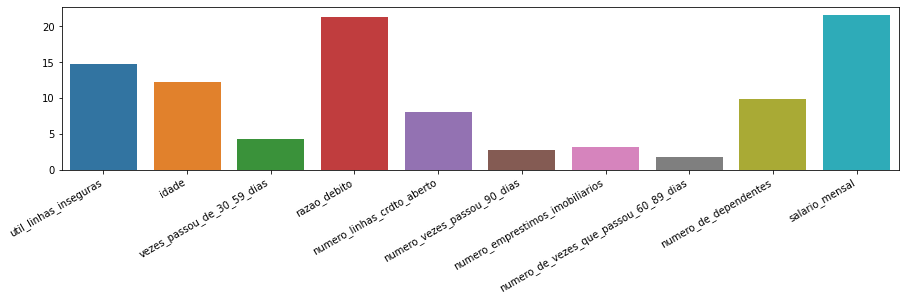

In [127]:
pesos_relativos = [ (p/np.sum(list(pesos.values())))*100 for p in list(pesos.values()) ]
plt.figure(figsize=(15, 3))
plt.xticks(rotation=30, ha='right', va='top')
sns.barplot(list(pesos.keys()),pesos_relativos)

Visualizando os resultados, é razoável considerar que razao_debito e salario_mensal sejam os maiores influenciadores deste modelo.

Salvando o resultado:

In [108]:
df_test.to_csv('teste_predict.csv')